In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit
def bod(i:int,j:int,m:int,n:int,a:float,b:float,c:float):
    '''i je uhel theta, j je uhel fi, m a n jsou skalary urcujici veliskot samplovani,
    a, b, c je mira toho jak je koule roztazena v ose x, y, z'''
    x= a * np.sin(np.pi * i/m) * np.cos(2 * np.pi * j/n)
    y= b * np.sin(np.pi * i/m) * np.sin(2 * np.pi * j/n)
    z= c * np.cos(np.pi * i/m)
    return np.array([x,y,z])

In [6]:
%timeit bod(1,1,1,1,1,1,1)

The slowest run took 9.84 times longer than the fastest. This could mean that an intermediate result is being cached.
8.24 µs ± 9.53 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
@njit
def ploska(i1:int,j1:int, i2:int,j2:int, i3:int,j3:int, m:int,n:int,a:float,b:float,c:float):
    L = bod(i2, j2, m, n, a, b, c) - bod(i1, j1, m, n, a, b, c)
    P = bod(i3, j3, m, n, a, b, c) - bod(i1, j1, m, n, a, b, c)
    return 1/2 * np.sqrt(np.sum(np.square(np.cross(L, P)))) #urcite je na to nejaka lepsi funkce v numpy ale nepodarilo se mi ji rychle najit

In [8]:
@njit
def priblizna_plocha(m,n,a,b,c):
    suma = 0
    for i in range(n):
        for j in range(m):
            suma += ploska(i,j, i+1,j, i+1,j+1, m, n, a, b, c) + ploska(i,j, i,j+1, i+1,j+1, m, n, a, b, c)
    return suma

In [9]:
@njit
def presnejsi_plocha(m,n,a,b,c):
    return 1/120 * (5 * priblizna_plocha(m, n, a, b, c)
                     - 128 * priblizna_plocha(2*m, 2*n, a, b, c)
                     + 243 * priblizna_plocha(3*m, 3*n, a, b, c)
                     )


In [10]:
#main [5a]
N = [8, 16, 32, 64, 128, 256, 512]
for n in N:
    print(f'{n}\t {priblizna_plocha(n,n,1,1,1)}\t {presnejsi_plocha(n,n,1,1,1)}')

8	 11.706503873103747	 12.566352040962453
16	 12.346122668960442	 12.566370323953102
32	 12.510971203142395	 12.566370609817605
64	 12.552499557639992	 12.566370614287841
128	 12.562901523139042	 12.566370614358732
256	 12.565503258586467	 12.566370614354868
512	 12.566153770234074	 12.56637061438331


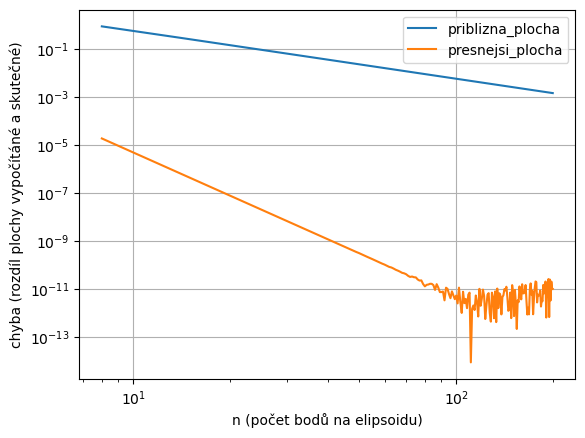

In [11]:
# 5 B

presna_plocha = np.pi * 4
# abychom je mohli zpracovat v cyklu hodnoty dáme do pole
parametry = [(1,1,1, presna_plocha)]

# zvolíme geometrickou řadu počtu vrcholů lomené křivky
pocty =  range(8, 200)
len_pocty = len(pocty)

err = []
err2 = []

for a,b,c, presna_plocha in parametry:        # pro jednotlivé křivky
  priblizne_plochy = np.zeros(len_pocty)
  priblizne_plochy2 = np.zeros(len_pocty)
  for k in range(len_pocty): # pro různé počty úseků lomenice
    priblizne_plochy[k] = priblizna_plocha(int(pocty[k]), int(pocty[k]), a=a, b=b, c=c)
    priblizne_plochy2[k] = presnejsi_plocha(int(pocty[k]), int(pocty[k]), a=a, b=b, c=c)

  # spočti odchylku
  chyby = abs(priblizne_plochy - presna_plocha)
  chyby2 = abs(priblizne_plochy2 - presna_plocha)
  #preda odchylky do globalni promene, aby jsme je mohli pouzit pro dalsi vypocet
  err.append(chyby)
  err2.append(chyby2)
  # a namaluj ji
  plt.plot(pocty, chyby, label=f'priblizna_plocha')
  plt.plot(pocty, chyby2, label=f'presnejsi_plocha')


plt.yscale('log')       # logaritmický průběh os
plt.xscale('log')
plt.xlabel('n (počet bodů na elipsoidu)')
plt.ylabel('chyba (rozdíl plochy vypočítáné a skutečné)')
plt.legend()            # zobraz popisek daný "label=..."
plt.grid()
plt.show()


pro priblizna_plocha je to 862813
pro presnejsi_plocha je to 61


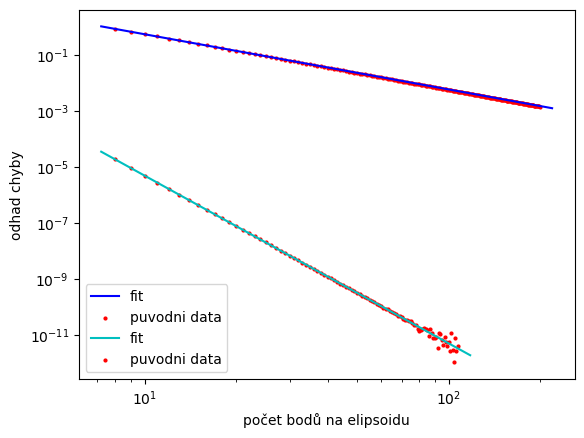

In [33]:
# 5 C
from scipy.optimize import curve_fit

def fit_f(x, a, b):
        '''fitovana funkce, v nasem pripade takova, co je po logaritmovani linearni'''
        return a*(x**(-b))

def fit_and_plot(pocty, data, c="r"):
    '''fitovani'''
    pars, cov = curve_fit(f=fit_f, xdata=pocty, ydata=data)
    
    '''plotovani'''
    p = np.linspace(min(pocty)*0.9, max(pocty)*1.1, 100000)
    plt.plot(p, fit_f(p, *pars), c=c, label="fit")
    plt.scatter(pocty, data, c="r", label="puvodni data", s=4)
    return pars


parameters = fit_and_plot(pocty,err[0], "b")
parameters2 = fit_and_plot(pocty[:100],err2[0][:100], "c") 
#omezime fitovani hodnot jen na prvnich sto, protoze vidime z predchoziho grafu ze uz dale prevazuje sum

def inverse_fit(y, a, b):
      '''inverzni funkce k fitovane funkci'''
      return (y/a)**(1/-b)
      

print(f'pro priblizna_plocha je to {round(inverse_fit(1e-10, *parameters))+1}')
print(f'pro presnejsi_plocha je to {round(inverse_fit(1e-10, *parameters2))+1}')
plt.xlabel(r"počet bodů na elipsoidu")
plt.ylabel(r"odhad chyby")
plt.legend()
plt.yscale('log')       
plt.xscale('log')
plt.show()

# 5 C
'''
pro priblizna_plocha je to 862813
pro presnejsi_plocha je to 61
'''

In [65]:
# 5 D
zadani = [(1,2,3), (2,3,1), (3,1,2)]
m = 61
for a,b,c, in zadani:
    print(presnejsi_plocha(m, m, a,b,c))

48.8821463021226
48.88214630206519
48.88214630223123


In [47]:
# pro urceni casove narocnosti fce priblizna_plocha urcite potrebujeme vice nez 3 datove body
x_values = [128, 256, 512, 768, 1024, 1536, 2048, 4096]
'''
#mereni
for i in x_values:
    %timeit priblizna_plocha(i, i, 3, 1, 2)
'''
    
'''vysledky'''
cpu_times = [26.2, 104, 422, 3430, 2500, 4350, 7850, 32700]
#v ms
std_rel = [1.31/26.2, 2.2/104, 6.57/442, 3.31/3.43, 219/2500, 226/4350, 286/7850, 766/32700]

'''
26.2 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
104 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
422 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 10.19 times longer than the fastest. This could mean that an intermediate result is being cached.
3.43 s ± 3.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.5 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.35 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.85 s ± 286 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.7 s ± 766 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
'''

'\n26.2 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)\n104 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)\n422 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)\nThe slowest run took 10.19 times longer than the fastest. This could mean that an intermediate result is being cached.\n3.43 s ± 3.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)\n2.5 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)\n4.35 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)\n7.85 s ± 286 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)\n32.7 s ± 766 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)\n'

In [56]:
std_rel

[0.05,
 0.021153846153846155,
 0.014864253393665159,
 0.9650145772594751,
 0.0876,
 0.051954022988505745,
 0.03643312101910828,
 0.023425076452599388]

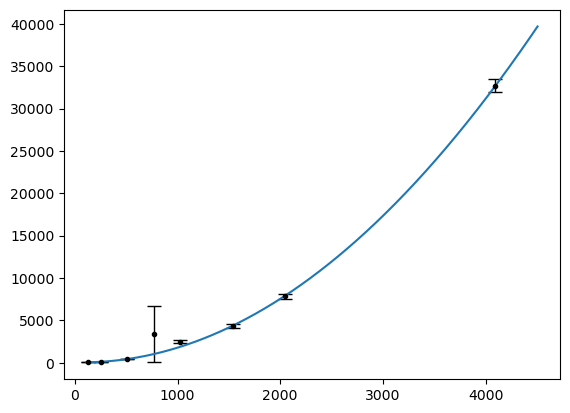

1501824826 ms = 17.375 dnů


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_exp(x, a, b, c):
    return a*np.exp(b*x+c)

def fit_quadr(x, a, b, c):
    return a*x**2 + b*x + c

#pars, cov = curve_fit(f=fit_exp, xdata=x_values, ydata=cpu_times, sigma=std_rel)
pars2, cov2 = curve_fit(f=fit_quadr, xdata=x_values, ydata=cpu_times, sigma=std_rel)

p = np.linspace(min(x_values)*0.9, max(x_values)*1.1, 10000)

plt.errorbar(x_values, cpu_times, yerr=np.multiply(std_rel,cpu_times), fmt=".", elinewidth=1, capsize=5, ecolor='black',color='black')
#plt.plot(p, fit_exp(p, *pars))
'''
myslel jsem ze by se mohlo jednat i o exponencialni funkci ale kvuli tomu ze se mi ji nepodarilo nafitovat
jsem se podival na casovou narocnost jednotlivych smyscek a dospel jsem k nazoru ze by melo jednat o kvadratickou funkci
'''
plt.plot(p, fit_quadr(p, *pars2))
plt.show()
'''to ze se jedna o polnomialni rust muzeme taky videt kdyz si dame meritko y v logaritmicke skale'''
#plt.yscale("log")

# 5 E
m = 862813
ocekavany_cas = fit_quadr(m, *pars2)
print(f"{int(ocekavany_cas)} ms = {(((ocekavany_cas//1000)//60)//60)/24} dnů")